In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
import time
from random import randint, getrandbits

#%matplotlib notebook
import matplotlib.pyplot as plt
#%pylab inline

## Генераторы графов

In [2]:
# функция возвращает случайный простой граф в моделе Gnp 
# вероятность ребра p = 2*m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnp_graph(n, m, seed=42):
  edge_p = 2*m/(n*(n-1))
  g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed)
  
  return nx.convert.to_dict_of_lists(g)

In [3]:
# функция возвращает случайный ориентированный граф в моделе Gnp 
# вероятность ребра p = m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnp_digraph(n, m, seed=42):
  edge_p = m/(n*(n-1))
  g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed,True)
  
  return nx.convert.to_dict_of_lists(g)

In [4]:
# функция возвращает случайный простой граф в моделе Gnm 
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnm_graph(n, m, seed=42):
  g = nx.random_graphs.gnm_random_graph(n,m,seed)

  return nx.convert.to_dict_of_lists(g)

In [5]:
# функция возвращает случайный ориентированный граф в моделе Gnm
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_Gnm_digraph(n, m, seed=42):
  g = nx.random_graphs.gnm_random_graph(n,m,seed,True)

  return nx.convert.to_dict_of_lists(g)

In [6]:
# функция возвращает связный ориентированный Ейлеров граф
# в графе n вершин, k - параметр, от которого зависти генерация
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_Euler_digraph(n, k=8):
  in_degs, out_degs = [k]*n, [k]*n 
  G = nx.generators.directed_havel_hakimi_graph(in_degs, out_degs)
  WCCs = list(nx.algorithms.components.weakly_connected_components(G))
  if len(WCCs) > 1:
    connecting_nodes = []
    for WCC in WCCs:
      some_vertex_of_WCC = next(iter(WCC))
      connecting_nodes.append(some_vertex_of_WCC)
    for i in range(1, len(connecting_nodes)):
      G.add_edge(connecting_nodes[i-1],connecting_nodes[i])
      G.add_edge(connecting_nodes[i],connecting_nodes[i-1])
    
  return nx.convert.to_dict_of_lists(G)

In [7]:
# утилитарная функция, переводящая таплы вида (1, 0, 0, 1)
# в числа, интерпетируя эту запись как число в двоичной записи
# эта функция нужна для следующей функции
def get_index_from_binary(tup):
  n = len(tup)
  mult = 1
  res = 0
  for i in range(n):
    res += tup[i]*mult
    mult *= 2
  return res

# функция возвращает связный ориентированный регулярный Ейлеров граф
# входные и выходные степени всех вершин совпадают и равны half_dim
# число вершин равно 4**half_dim
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_hypercube_digraph(half_dim):
  G = nx.generators.hypercube_graph(half_dim*2)
  directed_G = nx.DiGraph()
  Euler_circuit_G = nx.algorithms.eulerian_circuit(G)
  for (u,v) in Euler_circuit_G:
    directed_G.add_edge(get_index_from_binary(u), get_index_from_binary(v))
  return nx.convert.to_dict_of_lists(directed_G)

# Алгоритмы сортировки

In [59]:
def counting_sort(arr, shift):
    mask = 65535 # it is 2^16-1
    if all(type(x) == int for x in arr):
        sorted_array = [0 for _ in range(len(arr))]
    else:
        sorted_array = [[] for _ in range(len(arr))]
    counting_array = [0 for _ in range(mask + 1)]
    if all(type(x) == int for x in arr):
        for x in arr:
            counting_array[(np.uint64(x) >> np.uint64(shift)) & np.uint64(mask)] += 1
    else:
        for x in arr:
            counting_array[(np.uint64(x[0]) >> np.uint64(shift)) & np.uint64(mask)] += 1
    for i in range(1, len(counting_array)):
        counting_array[i] += counting_array[i-1]
    if all(type(x) == int for x in arr):
        for i in range(len(arr) - 1, -1, -1):
            pos = counting_array[(np.uint64(arr[i]) >> np.uint64(shift)) & np.uint64(mask)] - 1
            sorted_array[pos] = arr[i]
            counting_array[(np.uint64(arr[i]) >> np.uint64(shift)) & np.uint64(mask)] -= 1
    else:
        for i in range(len(arr) - 1, -1, -1):
            pos = counting_array[(np.uint64(arr[i][0]) >> np.uint64(shift)) & np.uint64(mask)] - 1
            sorted_array[pos] = arr[i]
            counting_array[(np.uint64(arr[i][0]) >> np.uint64(shift)) & np.uint64(mask)] -= 1
    return sorted_array

In [9]:
def insertion_sort(A, start = 0, finish = 0):
    if finish == 0:
        finish = len(A) - 1
    for x in range(start, finish + 1):
        curr_x = A[x]
        i = x - 1
        while i >= 0 and curr_x < A[i]:
            A[i+1] = A[i]
            i -= 1
        A[i+1] = curr_x
    return A

In [10]:
# поразрядная сортировка
# возвращает итоговую перестановку эелементов массива A
# для того, чтобы можно было переставить элементы в любом другом массиве
def radix_argsort(A):
  if len(A) == 0 or len(A) == 1:
    return A

  A = counting_sort(A, 0)
  A = counting_sort(A, 16)
  A = counting_sort(A, 32)
  A = counting_sort(A, 48)
  return A

In [11]:
# карманная сортировка
# возвращает итоговую перестановку эелементов массива A
# для того, чтобы можно было переставить элементы в любом другом массиве
def bucket_argsort(A):
  n = len(A)
  args = [x for x, _, _ in A]
  #print(args)
  if not args:
    return []
  b = max(args)
  if not b:
    b = 1
  bucket_array = [[] for _ in range(n+1)]
  sorted_array = []
  for x, first_vertex, second_vertex in A:
    bucket_array[int(n*x/b)].append([x, first_vertex, second_vertex])
  for i in range(n-1):
    insertion_sort(bucket_array[i])
  for bucket in bucket_array:
    sorted_array.extend(bucket)
  return sorted_array

In [12]:
def lomuto_partition(A, start, finish, _lambda):
    i = 0
    j = 0
    _lambda_value = A[_lambda]
    A[_lambda], A[finish - 1] = A[finish - 1], A[_lambda]
    while j < (len(A) - 1):
        if A[j] >= _lambda_value:
            j += 1
        else:
            A[i], A[j] = A[j], A[i]
            i += 1
            j += 1
    A[finish - 1], A[i] = A[i], A[finish - 1]
    #print(A)
    return i

In [13]:
# быстрая сортировка
# возвращает итоговую перестановку эелементов массива A
# для того, чтобы можно было переставить элементы в любом другом массиве
L = 100 # Num of elements to call simple sort function
def quick_sort(A, start, finish):
  while finish - start > L:
    lambda_index = randint(start, finish-1)
    lambda_index = lomuto_partition(A, start, finish, lambda_index)
    if (lambda_index - start) < (finish - lambda_index):
      quick_sort(A, start, lambda_index)
      start = lambda_index + 1
    else:
      quick_sort(A, lambda_index + 1, finish)
      finish = lambda_index
  A = insertion_sort(A, start, finish)
  return A


def quick_argsort(A):
  start = 0
  finish = len(A) - 1
  return quick_sort(A, start, finish)

# Алгоритмы для поиска мостов

In [14]:
def dfs_for_bridges_determ(vertex, graph, colors:list, Tst, M_stats, counter, parents, bridges):
    my_stack = [vertex]
    while len(my_stack):
        vertex = my_stack[-1]
        has_child = False
        if colors[vertex] == 'white':
            colors[vertex] = 'grey'
            Tst[vertex] = counter
            counter += 1
            M_stats[vertex] = Tst[vertex]
        for selected_vertex in graph[vertex]:
            if selected_vertex == parents[vertex] or selected_vertex == -1:
                continue
            if colors[selected_vertex] == 'white':
                has_child = True
                parents [selected_vertex] = vertex
                my_stack.append(selected_vertex)
                break
            else:
                M_stats[vertex] = min(M_stats[vertex], Tst[selected_vertex])
        if not has_child:
            for selected_vertex in graph[vertex]:
                if selected_vertex != parents[vertex] and selected_vertex != -1:
                    M_stats[vertex] = min(M_stats[vertex], M_stats[selected_vertex])
                    if M_stats[selected_vertex] > Tst[vertex]:
                        bridges.append((min(selected_vertex, vertex), max(selected_vertex, vertex)))
            colors[vertex] = 'black'
            my_stack.pop()

In [15]:
def dfs_for_bridges_rand(vertex, graph, weights, colours, parents):
    my_stack = [vertex]
    while len(my_stack):
        vertex = my_stack[-1]
        has_child = False
        colours[vertex] = 'grey'
        for selected_vertex in graph[vertex]:
            if selected_vertex != parents[vertex]:
                if colours[selected_vertex] == 'white':
                    #dfs_for_bridges_rand(selected_vertex, graph, weights, colours, vertex)
                    my_stack.append(selected_vertex)
                    parents[selected_vertex] = vertex
                    has_child = True
                    break
                else:
                    if (min(selected_vertex, vertex), max(selected_vertex, vertex)) not in weights.keys():
                        weights[(min(selected_vertex, vertex), max(selected_vertex, vertex))] = getrandbits(64)
        if not has_child:
            updated_weight = np.uint64(0)
            for selected_vertex in graph[vertex]: 
                if selected_vertex == parents[vertex]: continue
                    #updated_weight = np.uint64(0)
                if (min(selected_vertex, vertex), max(selected_vertex, vertex)) in weights.keys():
                    updated_weight ^= np.uint64(weights[(min(selected_vertex, vertex), max(selected_vertex, vertex))])
            weights[(min(parents[vertex], vertex), max(parents[vertex], vertex))] = updated_weight
            colours[vertex] = 'black'
            my_stack.pop()

In [16]:
# детерминированный алгоритм для поиска мостов
# на вход поступает граф представленный списком смежности
# саписок представлен как словарь(хеш-таблица) списков
# выход представляет собой список ребер, являющихся мостами 
def compute_bridges_determ(adj_list):
  #adj_list[-1] = [i for i in range(0, len(adj_list))]
  counter = 0
  colors = ['white' for _ in adj_list]
  Tst = [0 for _ in adj_list]
  parents = [-1 for _ in adj_list]
  M_stats = [np.inf for _ in adj_list]
  bridges = []
  for i in adj_list:
    if colors[i] == 'white':  
      dfs_for_bridges_determ(i, adj_list, colors, Tst, M_stats, counter, parents, bridges)
  bridges = set(filter(lambda x: x[0] != -1 and x[1] != -1, bridges))
  #adj_list.pop(-1)
  return set(bridges)

In [17]:
# рандомизированный алгоритм для поиска мостов
# на вход поступает граф представленный списком смежности
# саписок представлен как словарь(хеш-таблица) списков 
# выход представляет собой список ребер, являющихся мостами с большой вероятностью
def compute_bridges_rand(adj_list):
  colours = ['white' for _ in adj_list]
  weights = dict()
  parents = [-1 for _ in adj_list]
  for i in adj_list:
    if colours[i] == 'white':
      dfs_for_bridges_rand(i, adj_list, weights, colours, parents)
  bridges = []
  for i in weights.keys():
    if weights[i] == 0 and i[0] != -1:
      bridges.append(i)
  return set(bridges)

In [18]:
# рандомизированный алгоритм для поиска 2-мостов
#
# на вход поступает граф представленный списком смежности и алгоритм сортировки для меток на ребрах
# саписок представлен как словарь(хеш-таблица) списков 
#
# выходом алгоритма является список списков ребер
# в каждом списке любая пара ребер должна с высокой вероятностью образовывать 2-мост
# например, если выходом является спискок [[e1, e2, e3],[e4, e5]]
# то с высокой вероятностью 2-мостами будут пары ребер: (e1,e2), (e1,e3), (e2,e3), (e4,e5)
# ребра здесь это пары вершин типа e1 = (1,2)
def compute_2bridges_rand(adj_list, sort_fun):
  weights = dict()
  colours = ['white' for _ in adj_list]
  parents = [-1 for _ in adj_list]
  for i in adj_list:
    dfs_for_bridges_rand(i, adj_list, weights, colours, parents)
  marked_edges = []
  for i in weights.keys():
    if i[0] != -1:
      marked_edges.append([weights[i], i[0], i[1]])
  #print(marked_edges)
  marked_edges = sort_fun(marked_edges)
  all_2_bridges = []
  current_weight = 0
  tmp = []
  for selected_edge in marked_edges:
    #print(selected_edge)
    if current_weight == selected_edge[0]:
      tmp.append((selected_edge[1], selected_edge[2]))
    else:
      if not len(tmp):
        all_2_bridges.append(tmp)
      current_weight = selected_edge[0]
      tmp = [(selected_edge[1], selected_edge[2])]
  if len(tmp) > 1:
    all_2_bridges.append(tmp)
  return all_2_bridges

# Эйлеровы циклы

In [19]:
def edgeDFS(vertex, graph, colours):
    colours[vertex] = 'grey'
    my_stack = [vertex]
    while len(my_stack):
        vertex = my_stack[-1]
        colours[vertex] = 'grey'
        has_child = False
        for selected_v in graph[vertex]:
            if (colours[selected_v] == 'white'):
                has_child = True
                my_stack.append(selected_v)
                break
        if not has_child:
            colours[vertex] = 'black'
            my_stack.pop()

def check_for_euler_path(adj_list) -> bool:
    odd_vertex = 0
    deg = {i:0 for i in adj_list}
    colours = ['white' for _ in adj_list]
    for vertex in adj_list:
        deg[vertex] += len(adj_list[vertex])
        for neighbours in adj_list[vertex]:
            deg[neighbours] += 1
    for vertex in adj_list:
        if deg[vertex] & 1:
            odd_vertex += 1
    if odd_vertex > 0:
        print('This graph does not contain Euler path')
        return False
    for vertex in adj_list:
        if (len(adj_list[vertex]) > 0) and (colours[vertex] == 'white'):
            edgeDFS(vertex, adj_list, colours)
            break
    for vertex in adj_list:
        if (len(adj_list[vertex]) > 0) and (colours[vertex] == 'grey'):
            return False
    return True

def dfs_for_euler_circuit_digraph(adj_list):
    vertex = 0
    euler_path = []
    edges = set()
    for v in adj_list:
        for u in adj_list[v]:
            edges.add((v,u))
    #print(edges)
    #print()
    for u in adj_list:
        if len(adj_list[u]) & 1:
            vertex = u
            break
    my_stack = [vertex]
    while len(my_stack):
        w = my_stack[-1]
        found_edge = False
        for u in adj_list:
            #print((w,u))
            if (w, u) in edges:
                my_stack.append(u)
                edges.remove((w, u))
                found_edge = True
                break
        if not found_edge:
            euler_path.append(my_stack[-1])
            my_stack.pop()
    return euler_path

#функция вычисляющая эйлеров обход для данного ориентированного графа G 
#цикл кодируется списком ребер, например:
#(1,2), (2,4), (4, 7), (7,1)

def compute_Euler_circuit_digraph(adj_list):
    if not check_for_euler_path(adj_list):
        return []
    my_stack = dfs_for_euler_circuit_digraph(adj_list)
    #my_stack.reverse()
    answer = []
    my_stack.reverse()
    for i in range(1, len(my_stack)):
        answer.append((my_stack[i-1], my_stack[i]))
    return answer

    
    

# Арифметика в конечных кольцах и полях

In [20]:
# эта функция инвертирует x в Zp с помощью алгоритма Евклида
# выходом является целое число y, такое что
# 1) 0 < y < p 
# 2) (xy) mod p = 1 
# если число невозможно инвертировать, функция возвращает 0

def invert_in_Zp_Euclead(p, x):
  # (p, x)
  if x == 0:
    return 0
  num1 = p
  num2 = x
  matrix = [[1, 0], [0,1]]
  _x = 0
  _y = 0
  while num2 > 0:
    q = num1//num2
    r = num1 - q*num2
    _x = matrix[0][0] - matrix[1][0]*q
    _y = matrix[0][1] - matrix[1][1]*q
    num1, num2 = num2, r
    matrix[0][0], matrix[1][0] = matrix[1][0], _x
    matrix[0][1], matrix[1][1] = matrix[1][1], _y
  #print(matrix)
  _x, _y = matrix[0][0], matrix[0][1]
  if num1 == 1:
    return _y if _y > 0 else p + _y
  else:
    return 0

In [21]:
def fast_power(x, n):
    if n == 1:
        return x
    if n == 0:
        return 1
    if n & 1:
        return fast_power(x*x, (n//2)) * x
    else:
        return fast_power(x*x, n//2)



In [22]:
# эта функция инвертирует x в Zp с помощью малой теоремы Ферма и алгоритма быстрого возведения в степень
# выходом является целое число y, такое что
# 1) 0 < y < p 
# 2) (xy) mod p = 1 
# если число невозможно инвертировать, функция возвращает 0
def invert_in_Zp_Ferma(p,x):
  #этот код нужно заменить на Ваш
  if p != 0 or p != 1:
    if (fast_power(x, p-1) % p) == 1 :
      return fast_power(x, p-2) % p
  return 0

# Стресс тесты

In [23]:
def stress_test_bridges_determ(n, m, iterations_num=1000):
  for i in range(iterations_num):
    G = get_random_simple_Gnp_graph(n, m, i)
    briges_test = compute_bridges_determ(G)
    bridges_true = set(nx.algorithms.bridges(nx.Graph(G)))
    diff = list(bridges_true.symmetric_difference(briges_test))
    if len(diff) > 0:
      raise Exception(f"Неверное решение в детерминированном алгоритме поиска мостов, n: {n}, m: {m}, seed: {i}")
  print(f"Стресс тест для детерминированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}")
    

In [24]:
def stress_test_bridges_rand(n, m, iterations_num=1000):
  exp_err = m * (1/ (2**64))
  for i in range(iterations_num):
    G = get_random_simple_Gnp_graph(n, m, i)
    briges_test = compute_bridges_rand(G)
    bridges_true = set(nx.algorithms.bridges(nx.Graph(G)))
    diff = list(bridges_true.symmetric_difference(briges_test))
    if len(diff) > exp_err:
      raise Exception(f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {len(diff)}, seed: {i}")
  print(f"Стресс тест для рандомизированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}")
    

In [25]:
def stress_test_finite_fields(p = 2**61-1, iterations_num = 100000):
  for i in range(iterations_num):
    x = np.random.randint(1, p)
    inverse_Euclead_x = invert_in_Zp_Euclead(p,x)
    inverse_Ferma_x = invert_in_Zp_Ferma(p,x)
    if( np.gcd(p,x) == 1 ):
      if (x * inverse_Euclead_x - 1) % p != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом Евклида, p: {p}, x: {x}")
      if (x * inverse_Ferma_x - 1) % p != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом быстрого возведения в степень, p: {p}, x: {x}")
    else :
      if inverse_Euclead_x != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом Евклида, p: {p}, x: {x}")
      if inverse_Ferma_x != 0:
        raise Exception(f"Неправильное инвертирование алгоритмом быстрого возведения в степень, p: {p}, x: {x}")  
  print(f"Стресс тест для арифметики в конечных полях пройден!, p: {p}, iterations_num: {iterations_num}")

In [26]:
def stress_test_2bridges_rand(n, m, sort, iterations_num=1000):
  exp_err = (m*(m-1)/2) * (1/ (2**64))
  for iteration in range(iterations_num):
    err_num = 0
    G = nx.Graph(get_random_simple_Gnp_graph(n, m, iteration))
    bridges_test = compute_2bridges_rand(G,sort)
    for edge_group in bridges_test:
      for e1 in range(len(edge_group)):
        for e2 in range(e1+1,len(edge_group)):
          G_with_deleted_2bridge = G.copy()
          G_with_deleted_2bridge.remove_edge(*edge_group[e1])
          G_with_deleted_2bridge.remove_edge(*edge_group[e2])
          if nx.connected.number_connected_components(G) == nx.connected.number_connected_components(G_with_deleted_2bridge):
            ++err_num
    if err_num > exp_err:
      raise Exception(f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {err_num}, sort: {sort}, seed: {iteration}")
  print(f"Стресс тест для рандомизированного поиска мостов пройден!, n: {n}, m: {m}, , sort: {sort}, iterations_num: {iterations_num}")

In [27]:
def test_Euler_circuit(G, test_circuit):
  edges_dict = {}
  m = 0
  for (v,neib) in G.items():
    for u in neib:
      edges_dict[(v,u)] = False
      m += 1

  l = len(test_circuit)
  if m != l:
    return False

  for i in range(1,m):
    if test_circuit[i-1][1] != test_circuit[i][0]:
      return False
  if test_circuit[l-1][1] != test_circuit[0][0]:
    return False

  for e in test_circuit:
    if edges_dict.get(e, True) == True:
      return False
    else:
      edges_dict[e] = True
    
  return True

# max_n должно быть строго больше чем 10
def stress_test_Euler_circuit_digraph(max_n, iterations_num=1000):
  for iteration in range(iterations_num):
    n = np.random.randint(10, max_n)
    k = np.floor(n/4)
    G = get_Euler_digraph(n,k)
    test_circuit = compute_Euler_circuit_digraph(G)
    if not test_Euler_circuit(G, test_circuit):
      raise Exception(f"Неправильный Эйлеров обход, функция генерации: get_Euler_digraph, n: {n}, k: {k}")
  print(f"Стресс тест для ориентированных Эйлеровых циклов пройден, max_n: {max_n}, iterations_num: {iterations_num}")

In [61]:
vertex_quantity = 10000
stress_test_bridges_determ(vertex_quantity, 10*vertex_quantity, 10)
stress_test_bridges_rand(vertex_quantity, 10*vertex_quantity, 10)

stress_test_finite_fields(3323, 1000)

vertex_quantity = 1000
print('10*n')

stress_test_2bridges_rand(vertex_quantity, 10 * vertex_quantity, radix_argsort, 10)
stress_test_2bridges_rand(vertex_quantity, 10 * vertex_quantity, bucket_argsort, 10)
stress_test_2bridges_rand(vertex_quantity, 10 * vertex_quantity, quick_argsort, 10)

print('(N^2)/100')

stress_test_2bridges_rand(vertex_quantity, int((vertex_quantity**2)/100), radix_argsort, 10)
stress_test_2bridges_rand(vertex_quantity, int((vertex_quantity**2)/100), bucket_argsort, 10)
stress_test_2bridges_rand(vertex_quantity, int((vertex_quantity**2)/100), quick_argsort, 10)

print('n*log2(n)')

stress_test_2bridges_rand(vertex_quantity, int(vertex_quantity * np.log2(vertex_quantity)), radix_argsort, 10)
stress_test_2bridges_rand(vertex_quantity, int(vertex_quantity * np.log2(vertex_quantity)), bucket_argsort, 10)
stress_test_2bridges_rand(vertex_quantity, int(vertex_quantity * np.log2(vertex_quantity)), quick_argsort, 10)

stress_test_Euler_circuit_digraph(1000, 10)

Стресс тест для детерминированного поиска мостов пройден!, n: 10000, m: 100000, iterations_num: 10
Стресс тест для рандомизированного поиска мостов пройден!, n: 10000, m: 100000, iterations_num: 10
Стресс тест для арифметики в конечных полях пройден!, p: 3323, iterations_num: 1000
10*n
Стресс тест для рандомизированного поиска мостов пройден!, n: 1000, m: 10000, , sort: <function radix_argsort at 0x000001AC64C97280>, iterations_num: 10
Стресс тест для рандомизированного поиска мостов пройден!, n: 1000, m: 10000, , sort: <function bucket_argsort at 0x000001AC64C971F0>, iterations_num: 10
Стресс тест для рандомизированного поиска мостов пройден!, n: 1000, m: 10000, , sort: <function quick_argsort at 0x000001AC64C97670>, iterations_num: 10
(N^2)/100
Стресс тест для рандомизированного поиска мостов пройден!, n: 1000, m: 10000, , sort: <function radix_argsort at 0x000001AC64C97280>, iterations_num: 10
Стресс тест для рандомизированного поиска мостов пройден!, n: 1000, m: 10000, , sort: <fun

# Юнит тесты

In [29]:
def finite_fields_unit_tests():
  assert(invert_in_Zp_Euclead(6,4) == 0)
  assert(invert_in_Zp_Ferma(6,4) == 0)

  assert(invert_in_Zp_Euclead(6,2) == 0)
  assert(invert_in_Zp_Ferma(6,2) == 0)

  assert(invert_in_Zp_Euclead(2347,0) == 0)
  assert(invert_in_Zp_Ferma(2347,0) == 0)

  assert(invert_in_Zp_Euclead(7,6) == 6)
  assert(invert_in_Zp_Ferma(7,6) == 6)

  assert(invert_in_Zp_Euclead(2347,2346) == 2346)
  assert(invert_in_Zp_Ferma(2347,2346) == 2346)

  assert(invert_in_Zp_Euclead(1,0) == 0)
  assert(invert_in_Zp_Ferma(1,0) == 0)

  assert(invert_in_Zp_Euclead(2,0) == 0)
  assert(invert_in_Zp_Ferma(2,0) == 0)

  assert(invert_in_Zp_Euclead(2,1) == 1)
  assert(invert_in_Zp_Ferma(2,1) == 1)

In [30]:
def bridges_unit_test(G):
  test_bridges_determ = compute_bridges_determ(nx.convert.to_dict_of_lists(G))
  test_bridges_rand = compute_bridges_rand(nx.convert.to_dict_of_lists(G))
  true_bridges = set(nx.algorithms.bridges(nx.Graph(G)))
  determ_diff = list(true_bridges.symmetric_difference(test_bridges_determ))
  rand_diff = list(true_bridges.symmetric_difference(test_bridges_rand))
  assert len(determ_diff) == 0
  assert len(rand_diff) == 0

In [31]:
def two_bridges_unit_test(G, sort_fun):
  test_bridges = compute_2bridges_rand(nx.convert.to_dict_of_lists(G), sort_fun)
  for edge_group in test_bridges:
      for e1 in range(len(edge_group)):
        for e2 in range(e1+1,len(edge_group)):
          G_with_deleted_2bridge = G.copy()
          G_with_deleted_2bridge.remove_edge(*edge_group[e1])
          G_with_deleted_2bridge.remove_edge(*edge_group[e2])
          assert nx.connected.number_connected_components(G) < nx.connected.number_connected_components(G_with_deleted_2bridge)

In [38]:
def Euler_circuit_unit_tests():
  dims = [1, 2, 3, 4, 5, 6]
  for dim in dims:
    G = get_hypercube_digraph(dim)
    test_circuit = compute_Euler_circuit_digraph(G)
    assert(test_Euler_circuit(G,test_circuit))
    #print(f'{dim} passed')

In [39]:
finite_fields_unit_tests()
print("Все юнит тесты для арифметики в конечных полях пройдены успешно!")

bridges_unit_test(nx.generators.cycle_graph(10))
bridges_unit_test(nx.generators.path_graph(10))
bridges_unit_test(nx.generators.empty_graph(10))
bridges_unit_test(nx.generators.wheel_graph(10))
bridges_unit_test(nx.generators.trivial_graph())
bridges_unit_test(nx.generators.balanced_tree(3,3))
print("Все юнит тесты для поиска мостов пройдены успешно!")

sort_functions = [radix_argsort, bucket_argsort, quick_argsort]
for sort_fun in sort_functions:
  two_bridges_unit_test(nx.generators.cycle_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.path_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.empty_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.wheel_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.trivial_graph(), sort_fun)
  two_bridges_unit_test(nx.generators.balanced_tree(3,3), sort_fun)
print("Все юнит тесты для поиска 2-мостов пройдены успешно!")

Euler_circuit_unit_tests()
print("Все юнит тесты для поиска Эйлеровых циклов пройдены успешно!")

Все юнит тесты для арифметики в конечных полях пройдены успешно!
Все юнит тесты для поиска мостов пройдены успешно!
Все юнит тесты для поиска 2-мостов пройдены успешно!
Все юнит тесты для поиска Эйлеровых циклов пройдены успешно!


# Графики

In [40]:
def check_time(f, *args):
  start = time.time()
  f(*args)
  return time.time() - start


In [41]:
def plot_bridges(m_fun, start = 1000, step = 500, end = 10000, number_of_retryes = 10):
  _x, determ_Gnp_y, determ_Gnm_y, rand_Gnp_y, rand_Gnm_y = [], [], [], [], []
  for n in range(start,end,step):
    m = m_fun(n)
    time_Gnp_determ = 0.
    time_Gnp_rand = 0.
    time_Gnm_determ = 0.
    time_Gnm_rand = 0.
    for exp_num in range(number_of_retryes):
      g = get_random_simple_Gnp_graph(n,m,exp_num)
      time_Gnp_determ += check_time(compute_bridges_determ, g)
      time_Gnp_rand += check_time(compute_bridges_rand, g)
      g = get_random_simple_Gnm_graph(n,m,exp_num)
      time_Gnm_determ += check_time(compute_bridges_determ, g)
      time_Gnm_rand += check_time(compute_bridges_rand, g)
    time_Gnp_determ /= number_of_retryes
    time_Gnp_rand /= number_of_retryes
    time_Gnm_determ /= number_of_retryes
    time_Gnm_rand /= number_of_retryes
    _x.append(n)
    determ_Gnp_y.append(time_Gnp_determ)
    rand_Gnp_y.append(time_Gnp_rand)
    determ_Gnm_y.append(time_Gnm_determ)
    rand_Gnm_y.append(time_Gnm_rand)

  plt.plot(_x, determ_Gnp_y, label = "determ Gnp")
  plt.plot(_x, rand_Gnp_y, label = "rand Gnp")
  plt.plot(_x, determ_Gnm_y, label = "determ Gnm")
  plt.plot(_x, rand_Gnm_y, label = "rand Gnm")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel('number of vertices')
  plt.ylabel('time s.')
  plt.title(f"Эксперименты с мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
  #plt.figure(figsize= (1000,1000))
  plt.show()

In [68]:
def plot_2bridges(m_fun, start = 100, step = 50, end = 1000, number_of_retryes = 10):
  _x = []
  quick_Gnp, radix_Gnp, bucket_Gnp, standard_Gnp = [], [], [], []
  quick_Gnm, radix_Gnm, bucket_Gnm, standard_Gnm = [], [], [], []

  for n in range(start,end,step):
    m = m_fun(n)
    time_quick_Gnp, time_radix_Gnp, time_bucket_Gnp, time_standard_Gnp = 0., 0., 0., 0.
    time_quick_Gnm, time_radix_Gnm, time_bucket_Gnm, time_standard_Gnm = 0., 0., 0., 0.

    for exp_num in range(number_of_retryes):
      g = get_random_simple_Gnp_graph(n,m,exp_num)
      #time_quick_Gnp += check_time(compute_2bridges_rand,g,quick_argsort)
      time_bucket_Gnp += check_time(compute_2bridges_rand,g,bucket_argsort)
      time_radix_Gnp += check_time(compute_2bridges_rand,g,radix_argsort)
      time_standard_Gnp += check_time(compute_2bridges_rand,g,np.argsort)

      g = get_random_simple_Gnm_graph(n,m,exp_num)
      #time_quick_Gnm += check_time(compute_2bridges_rand,g,quick_argsort)
      time_bucket_Gnm += check_time(compute_2bridges_rand,g,bucket_argsort)
      time_radix_Gnm += check_time(compute_2bridges_rand,g,radix_argsort)
      time_standard_Gnm += check_time(compute_2bridges_rand,g,np.argsort)

    #time_quick_Gnp /= number_of_retryes
    time_bucket_Gnp /= number_of_retryes
    time_radix_Gnp /= number_of_retryes
    time_standard_Gnp /= number_of_retryes

    #time_quick_Gnm /= number_of_retryes
    time_bucket_Gnm /= number_of_retryes
    time_radix_Gnm /= number_of_retryes
    time_standard_Gnm /= number_of_retryes

    _x.append(n)

    #quick_Gnp.append(time_quick_Gnp)
    bucket_Gnp.append(time_bucket_Gnp)
    radix_Gnp.append(time_radix_Gnp)
    standard_Gnp.append(time_standard_Gnp)

    quick_Gnm.append(time_quick_Gnm)
    bucket_Gnm.append(time_bucket_Gnm)
    radix_Gnm.append(time_radix_Gnm)
    standard_Gnm.append(time_standard_Gnm)

  #plt.plot(_x, quick_Gnp, label = "quick Gnp")
  plt.plot(_x, bucket_Gnp, label = "bucket Gnp")
  plt.plot(_x, radix_Gnp, label = "radix Gnp")
  plt.plot(_x, standard_Gnp, label = "standard Gnp")

  #plt.plot(_x, quick_Gnm, label = "quick Gnm")
  plt.plot(_x, bucket_Gnm, label = "bucket Gnm")
  plt.plot(_x, radix_Gnm, label = "radix Gnm")
  plt.plot(_x, standard_Gnm, label = "standard Gnm")

  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel('number of vertices')
  plt.ylabel('time s.')
  plt.title(f"Эксперименты с 2-мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
  #plt.figure(figsize= (100000,100000))
  plt.show()

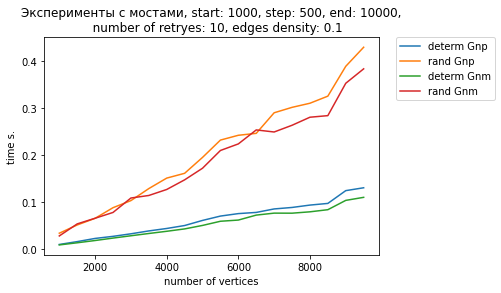

Total time: 136.08138632774353


In [43]:
print(f"Total time: {check_time(plot_bridges, lambda n: 10*n)}")

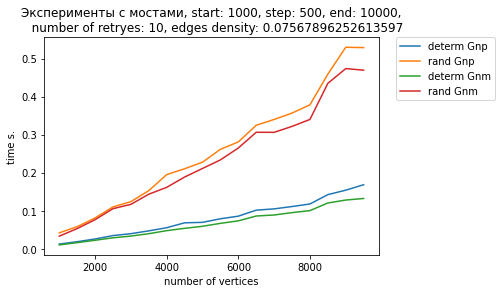

Total time: 172.0597996711731


In [44]:
print(f"Total time: {check_time(plot_bridges, lambda n: n*np.log2(n))}")

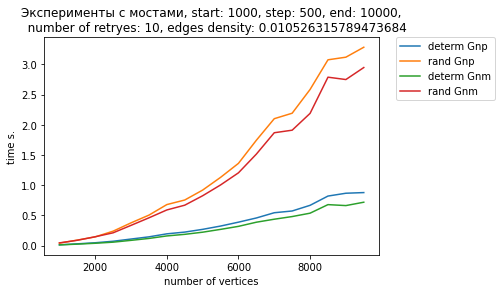

Total time: 846.368301153183


In [45]:
print(f"Total time: {check_time(plot_bridges, lambda n: (n**2)/100)}")

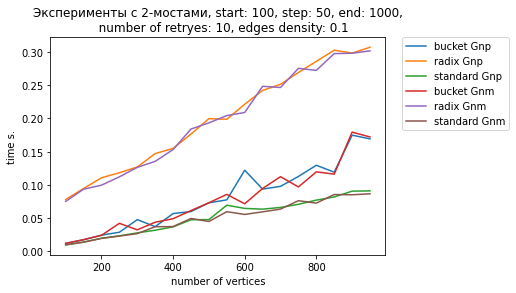

Total time: 122.77755641937256


In [71]:
print(f"Total time: {check_time(plot_2bridges, lambda n: 10*n)}")